In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
import datatable as dt

Load the data

In [3]:
#these files are too large to load into Github; they can be retrieved from the HMDA raw data
lar2020 = pd.read_csv("2020_lar/2020_lar_ohio_family_loans.csv", sep = " ", dtype = str)
lar2019 = pd.read_csv("2019_lar/2019_lar_ohio_family_loans.csv", sep = " ", dtype = str)
lar2018 = pd.read_csv("2018_lar/2018_lar_ohio_family_loans.csv", sep = " ", dtype = str)

#filter to only certain columns
filter_list = ['activity_year',
               'county_code',
               'applicant_sex',
               'co_applicant_race_1',
               'co_applicant_sex',
               'applicant_age',
               'co_applicant_age',
               'debt_to_income_ratio',
               'combined_loan_to_value_ratio',
               'applicant_race_1',
               'loan_amount',
               'income',
               'loan_term',
               'property_value',
               'action_taken', 
               'ffiec_msa_md_median_family_income',
               'tract_to_msa_income_percentage',
              'loan_purpose']
lar2020 = lar2020.loc[:, filter_list]
lar2019 = lar2019.loc[:, filter_list]
lar2018 = lar2018.loc[:, filter_list]

Append the separate data files into a single table

In [4]:
mortgage = lar2020.append(lar2019, ignore_index = True)
mortgage = mortgage.append(lar2018, ignore_index = True)

Filter data to refine the scope of analysis

In [5]:
mortgage = mortgage[mortgage['loan_purpose'] == '1'] #i only want mortgages that are for buying homes, not refinancings
mortgage.drop(['loan_purpose'], axis = 1, inplace = True)

Transform certain columns into the proper data type for analysis.

In [6]:
mortgage['activity_year'] = pd.to_numeric(mortgage['activity_year'], errors = 'coerce')
mortgage['property_value'] = pd.to_numeric(mortgage['property_value'], errors = 'coerce')
mortgage['ffiec_msa_md_median_family_income'] = pd.to_numeric(mortgage['ffiec_msa_md_median_family_income'], errors = 'coerce')
mortgage['loan_amount'] = pd.to_numeric(mortgage['loan_amount'], errors = 'coerce')
mortgage['loan_term'] = pd.to_numeric(mortgage['loan_term'], errors = 'coerce')
mortgage['combined_loan_to_value_ratio'] = pd.to_numeric(mortgage['combined_loan_to_value_ratio'], errors = 'coerce')
mortgage['income'] = pd.to_numeric(mortgage['income'], errors = 'coerce')

Filter out null values

In [7]:
mortgage = mortgage[mortgage['loan_term'] != '8888']
mortgage = mortgage[mortgage['loan_term'].isnull() == False]
mortgage = mortgage[mortgage['property_value'].isnull() == False]
mortgage = mortgage[mortgage['income'].isnull() == False]
mortgage = mortgage[mortgage['debt_to_income_ratio'].isnull() == False]
mortgage = mortgage[mortgage['action_taken'].isnull() == False]
mortgage = mortgage[mortgage['combined_loan_to_value_ratio'].isnull() == False]

Recode Dependent Variable "action_taken"

In [8]:
mortgage['action_taken'] = pd.to_numeric(mortgage['action_taken'], errors = 'coerce')
#filter out everything that's not a mortgage decision
mortgage = mortgage[mortgage['action_taken'] < 4]
conditions = [(mortgage['action_taken'] <= 2), (mortgage['action_taken'] == 3)]
recoded_conditions = [1, 0]
mortgage['action_taken'] = np.select(conditions, recoded_conditions, default = np.nan)

Recode Race Variable

In [9]:
mortgage['applicant_race_1'] = pd.to_numeric(mortgage['applicant_race_1'], errors = 'coerce')

#remove any entries that are 6, 7, 8 because it means that there is no race data
mortgage = mortgage[(mortgage['applicant_race_1'].isnull() == False)]
mortgage = mortgage[(mortgage['applicant_race_1'] != 7)]
mortgage = mortgage[(mortgage['applicant_race_1'] != 6)]

In [10]:
conditions = [(mortgage['applicant_race_1'] == 5), (mortgage['applicant_race_1'] != 5)]
recoded_conditions = [1, 0]
mortgage['applicant_race_1'] = np.select(conditions, recoded_conditions, default = np.nan)
mortgage['applicant_race_1'] = mortgage['applicant_race_1'].astype(object) #convert back to categorical

Recode applicant age to an ordinal variable

In [11]:
mortgage = mortgage[mortgage['applicant_age'] != '8888'] #remove 8888 entries from applicant
mortgage = mortgage[mortgage['applicant_age'] != '9999'] #remove 9999 entries from applicant
mortgage['applicant_age'] = np.where(mortgage['applicant_age'] == '<25', 1,
                                     np.where(mortgage['applicant_age'] == '25-34', 2,
                                              np.where(mortgage['applicant_age'] == '35-44', 3,
                                                       np.where(mortgage['applicant_age'] == '45-54', 4,
                                                                np.where(mortgage['applicant_age'] == '>74', 7,
                                                                         np.where(mortgage['applicant_age'] == '55-64', 5,
                                                                                  np.where(mortgage['applicant_age'] == '65-74', 6,0)))))))

Recode the debt-to-income ratio variable into consistent ranges and convert to numeric data type.

In [264]:
conditions = [(mortgage['debt_to_income_ratio'] == '<20%'),
              (mortgage['debt_to_income_ratio'] == '20%-<30%'),
              (mortgage['debt_to_income_ratio'] == '30%-<36%'),
              ((mortgage['debt_to_income_ratio'] == '36') | (mortgage['debt_to_income_ratio'] == '37') |
              (mortgage['debt_to_income_ratio'] == '38') | (mortgage['debt_to_income_ratio'] == '39') |
              (mortgage['debt_to_income_ratio'] == '40') | (mortgage['debt_to_income_ratio'] == '41') |
              (mortgage['debt_to_income_ratio'] == '42') | (mortgage['debt_to_income_ratio'] == '43')),
              ((mortgage['debt_to_income_ratio'] == '44') | (mortgage['debt_to_income_ratio'] == '45') |
              (mortgage['debt_to_income_ratio'] == '46') | (mortgage['debt_to_income_ratio'] == '47') | 
              (mortgage['debt_to_income_ratio'] == '48') | (mortgage['debt_to_income_ratio'] == '49')),
              (mortgage['debt_to_income_ratio'] == '50%-60%'),
             (mortgage['debt_to_income_ratio'] == '>60%'),
             (mortgage['debt_to_income_ratio'] == "Exempt")]
recoded_conditions = [1, 2, 3, 4, 5, 6, 7, "Exempt"]
mortgage['debt_to_income_ratio'] = np.select(conditions, recoded_conditions, default = np.nan)

In [265]:
mortgage['debt_to_income_ratio'] = pd.to_numeric(mortgage['debt_to_income_ratio'], errors = 'coerce')

Recode applicant sex variable and filter out incorrect values

In [17]:
mortgage = mortgage[mortgage['applicant_sex'] != '4'] #removes 4 entries
mortgage = mortgage[mortgage['applicant_sex'] != '3'] #removes 1552 entries

Create a dummy variable to indicate whether a co-applicant exists on the application.

In [18]:
mortgage['coapplicant_exists'] = np.where(mortgage['co_applicant_sex'] == '5', 1, 0)
mortgage['coapplicant_exists'] = mortgage['coapplicant_exists'].astype(object)
mortgage.head(10)

,activity_year,county_code,applicant_sex,co_applicant_race_1,co_applicant_sex,applicant_age,co_applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,applicant_race_1,loan_amount,income,loan_term,property_value,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,coapplicant_exists
0,2020,39023,1,8,5,5,9999,41,50.303,1.0,85000,33.0,360.0,165000.0,1.0,61100,0,1
1,2020,39049,2,5,1,2,25-34,30%-<36%,85.000,1.0,165000,89.0,360.0,195000.0,1.0,84600,0,0
2,2020,39153,1,8,5,3,9999,30%-<36%,95.000,1.0,85000,80.0,180.0,85000.0,1.0,76300,0,1
4,2020,39045,2,8,5,3,9999,50%-60%,96.500,0.0,265000,56.0,360.0,275000.0,1.0,84600,0,1
5,2020,39049,1,8,5,2,9999,40,75.000,0.0,45000,200.0,360.0,65000.0,1.0,84600,0,1
8,2020,39049,2,8,5,4,9999,<20%,89.918,0.0,225000,93.0,360.0,245000.0,1.0,84600,0,1
10,2020,39153,1,8,5,3,9999,44,102.000,1.0,125000,40.0,360.0,135000.0,1.0,76300,0,1
11,2020,39049,1,8,5,5,9999,20%-<30%,97.000,1.0,215000,50.0,360.0,215000.0,1.0,84600,0,1
12,2020,39049,1,5,2,4,45-54,47,95.000,1.0,305000,54.0,360.0,325000.0,1.0,84600,0,0
13,2020,39049,1,8,5,2,9999,38,75.000,1.0,105000,53.0,360.0,135000.0,1.0,84600,0,1


Remove the co-applicant variables that aren't the new dummy variable.  Removing the co-applicant variables reduces the large number of co-applicant-related missing values while avoiding inappropriate imputation.

In [19]:
mortgage.drop(['co_applicant_race_1', 'co_applicant_sex', 'co_applicant_age'], axis = 1, inplace = True)
mortgage['activity_year'] = mortgage['activity_year'].astype(object)

Remove outliers and filter out values that are extreme and don't make much sense.

In [20]:
mortgage = mortgage[mortgage['property_value'] < 10000000] #take out any homes over $10million because there seems to be some data quality issues, evident in the disproportionate income
mortgage = mortgage[mortgage['loan_term'] < 999] #take out any loan terms that don't make any sense (most loans are not more than 999 months)
mortgage = mortgage[mortgage['combined_loan_to_value_ratio'] < 200] #remove anything with a 1,000x loan to value ratio
mortgage = mortgage[mortgage['income'] < 5000] #remove income greater than $5 million
mortgage = mortgage[mortgage['income'] > 0] #remove income greater than $5 million

mortgage.shape

(423080, 15)

Convert the income percentage to numeric data type.

In [270]:
mortgage['tract_to_msa_income_percentage'] = pd.to_numeric(mortgage['tract_to_msa_income_percentage'], errors = 'coerce')

Generate descriptive statistics.

In [271]:
mortgage.describe()

,applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,loan_amount,income,loan_term,property_value,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage
count,423080.000000,423080.000000,423080.000000,4.230800e+05,423080.000000,423080.000000,4.230800e+05,423080.000000,423080.000000,423080.000000
mean,3.092725,3.444391,87.861302,1.829590e+05,91.659854,346.169221,2.181314e+05,0.931129,72060.882812,112.886998
std,1.399390,1.380902,13.490151,1.220969e+05,91.196349,49.741219,1.606860e+05,0.253235,7771.654585,40.042292
min,1.000000,1.000000,0.200000,5.000000e+03,1.000000,1.000000,5.000000e+03,0.000000,0.000000,0.000000
25%,2.000000,2.000000,80.000000,1.050000e+05,47.000000,360.000000,1.250000e+05,1.000000,66100.000000,87.000000
50%,3.000000,4.000000,95.000000,1.550000e+05,69.000000,360.000000,1.750000e+05,1.000000,73700.000000,108.000000
75%,4.000000,4.000000,96.500000,2.350000e+05,109.000000,360.000000,2.750000e+05,1.000000,77000.000000,134.000000
max,7.000000,7.000000,197.479000,4.505000e+06,4979.000000,720.000000,9.505000e+06,1.000000,84600.000000,371.000000


In [272]:
mortgage[mortgage['debt_to_income_ratio'].isnull() == True]

,activity_year,county_code,applicant_sex,applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,applicant_race_1,loan_amount,income,loan_term,property_value,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,coapplicant_exists


In [273]:
mortgage.kurtosis(axis = 0)

activity_year                           -1.505879
county_code                          61744.521650
applicant_sex                            4.663744
applicant_age                           -0.231679
debt_to_income_ratio                    -0.592597
combined_loan_to_value_ratio             5.744776
applicant_race_1                         3.607660
loan_amount                             32.536827
income                                 312.925245
loan_term                               11.243320
property_value                         119.654355
action_taken                             9.593964
ffiec_msa_md_median_family_income       15.563868
tract_to_msa_income_percentage           1.689566
coapplicant_exists                      -1.774568
dtype: float64

In [274]:
mortgage.skew(axis = 0)

activity_year                         -0.053571
county_code                         -218.886067
applicant_sex                          1.247644
applicant_age                          0.664536
debt_to_income_ratio                   0.111051
combined_loan_to_value_ratio          -1.810005
applicant_race_1                      -2.368046
loan_amount                            3.276345
income                                10.759976
loan_term                             -3.432959
property_value                         5.322303
action_taken                          -3.404984
ffiec_msa_md_median_family_income     -1.966847
tract_to_msa_income_percentage         0.761813
coapplicant_exists                    -0.474806
dtype: float64

Log-transform the property value, income, and loan amount variables.

In [275]:
#finally, I am going to log transform the property value and income variables
mortgage['property_value'] = np.where(mortgage['property_value'] != 0, np.log(mortgage['property_value']), 0)

In [276]:
mortgage['income'] = np.where(mortgage['income'] < 1, 1, mortgage['income'])

In [277]:
mortgage['income'] = np.where(mortgage['income'] > 1, np.log(mortgage['income']), 0)

In [278]:
mortgage['loan_amount'] = np.where(mortgage['loan_amount'] > 1, np.log(mortgage['loan_amount']), 0)

In [279]:
mortgage.rename(columns = {'property_value':'property_value_log', 'income':'income_log', 'loan_amount': 'loan_amount_log'}, inplace = True)

Generate certain histograms to understand the data distribution.

array([[<AxesSubplot:title={'center':'combined_loan_to_value_ratio'}>]],
      dtype=object)

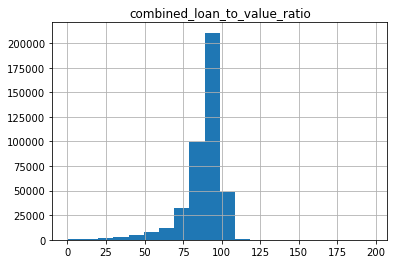

In [280]:
mortgage.hist(column='combined_loan_to_value_ratio', bins=20)

array([[<AxesSubplot:title={'center':'income_log'}>]], dtype=object)

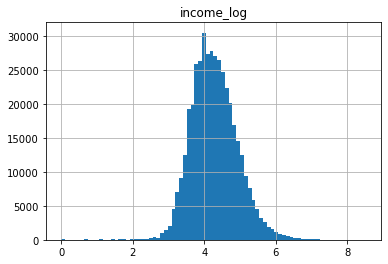

In [342]:
mortgage.hist(column='income_log', bins=80)

Generate Cronbach Alpha value to understand the consistency of the scales of my select ordinal variables in measuring mortgage approval likelihood.

In [281]:
def cronbach_alpha(items):
    items = pd.DataFrame(items)
    items_count = items.shape[1]
    variance_sum = float(items.var(axis=0, ddof=1).sum())
    total_var = float(items.sum(axis=1).var(ddof=1))
    
    return (items_count / float(items_count - 1) *
            (1 - variance_sum / total_var))

mortgage.columns

Index(['activity_year', 'county_code', 'applicant_sex', 'applicant_age',
       'debt_to_income_ratio', 'combined_loan_to_value_ratio',
       'applicant_race_1', 'loan_amount_log', 'income_log', 'loan_term',
       'property_value_log', 'action_taken',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'coapplicant_exists'],
      dtype='object')

In [282]:
cronbach_alpha(mortgage[['applicant_age', 'debt_to_income_ratio']])

0.008846125868418042

Evaluate Pearson correlation coefficients.

In [283]:
mortgage.corr(method = "pearson")

,applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,loan_amount_log,income_log,loan_term,property_value_log,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage
applicant_age,1.000000,0.004443,-0.305437,0.013475,0.123106,-0.109845,0.106493,-0.017936,0.003964,0.074948
debt_to_income_ratio,0.004443,1.000000,0.193874,0.037932,-0.295610,0.121759,-0.018834,-0.165993,0.000499,-0.045279
combined_loan_to_value_ratio,-0.305437,0.193874,1.000000,0.041767,-0.194361,0.280888,-0.266406,-0.059016,-0.059152,-0.188457
loan_amount_log,0.013475,0.037932,0.041767,1.000000,0.564340,0.205654,0.868510,0.080185,0.253872,0.469835
income_log,0.123106,-0.295610,-0.194361,0.564340,1.000000,-0.099155,0.648132,0.108171,0.170353,0.406004
loan_term,-0.109845,0.121759,0.280888,0.205654,-0.099155,1.000000,0.007296,-0.002333,0.034557,-0.021938
property_value_log,0.106493,-0.018834,-0.266406,0.868510,0.648132,0.007296,1.000000,0.093134,0.287164,0.546648
action_taken,-0.017936,-0.165993,-0.059016,0.080185,0.108171,-0.002333,0.093134,1.000000,0.082421,0.074941
ffiec_msa_md_median_family_income,0.003964,0.000499,-0.059152,0.253872,0.170353,0.034557,0.287164,0.082421,1.000000,0.130789
tract_to_msa_income_percentage,0.074948,-0.045279,-0.188457,0.469835,0.406004,-0.021938,0.546648,0.074941,0.130789,1.000000


In [284]:
mortgage.dtypes

activity_year                         object
county_code                           object
applicant_sex                         object
applicant_age                          int32
debt_to_income_ratio                   int64
combined_loan_to_value_ratio         float64
applicant_race_1                      object
loan_amount_log                      float64
income_log                           float64
loan_term                            float64
property_value_log                   float64
action_taken                         float64
ffiec_msa_md_median_family_income      int64
tract_to_msa_income_percentage         int64
coapplicant_exists                    object
dtype: object

Model 1: Linear Probability Model, simple

In [343]:
lpm1 = sm.formula.ols(formula ='action_taken ~ C(debt_to_income_ratio) + C(activity_year) + C(applicant_age) + C(applicant_sex) + C(applicant_race_1) + C(coapplicant_exists) + income_log + property_value_log + loan_amount_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

#print(lpm1.summary())

Model 2: Try curvilinear relationship - linear

In [344]:
curvy = smf.ols(formula = "action_taken ~ C(debt_to_income_ratio) + C(activity_year) + C(applicant_age) + C(applicant_sex) + C(applicant_race_1) + C(coapplicant_exists) + income_log + np.power(property_value_log,2) + np.power(loan_amount_log,2) + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage", data = mortgage).fit()
#print (curvy.summary())

Model 3. Logistic Regression where applicant age and debt-to-income ratio are treated as categorical variables, not ordinal.

In [346]:
logit1 = sm.formula.logit(formula ='action_taken ~ C(debt_to_income_ratio) + C(coapplicant_exists) + C(applicant_age) + C(activity_year) + C(applicant_sex) + C(applicant_race_1) + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

print(logit1.summary())

Optimization terminated successfully.
         Current function value: 0.212994
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:               423080
Model:                          Logit   Df Residuals:                   423055
Method:                           MLE   Df Model:                           24
Date:                Fri, 17 Dec 2021   Pseudo R-squ.:                  0.1504
Time:                        21:18:32   Log-Likelihood:                -90113.
converged:                       True   LL-Null:                   -1.0607e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -4.3028      0.180    -23

Convert the logistic model's probabilities

In [359]:
np.exp(logit1.params)

Intercept                            0.013530
C(debt_to_income_ratio)[T.2]         1.377871
C(debt_to_income_ratio)[T.3]         1.302275
C(debt_to_income_ratio)[T.4]         1.260544
C(debt_to_income_ratio)[T.5]         0.930176
C(debt_to_income_ratio)[T.6]         0.324725
C(debt_to_income_ratio)[T.7]         0.011907
C(coapplicant_exists)[T.1]           0.961042
C(applicant_age)[T.2]                1.095385
C(applicant_age)[T.3]                0.825284
C(applicant_age)[T.4]                0.721662
C(applicant_age)[T.5]                0.772424
C(applicant_age)[T.6]                0.936316
C(applicant_age)[T.7]                0.769702
C(activity_year)[T.2019]             1.145819
C(activity_year)[T.2020]             1.032354
C(applicant_sex)[T.2]                1.055638
C(applicant_sex)[T.6]                0.934131
C(applicant_race_1)[T.1.0]           1.746884
income_log                           1.065277
property_value_log                   1.539369
combined_loan_to_value_ratio      

Model 4: Logistic regression where debt-to-income and applicant age are treated as ordinal variables.

In [365]:
#switch the ordinal
logit2 = sm.formula.logit(formula ='action_taken ~ debt_to_income_ratio + C(activity_year) + applicant_age + C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1) + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

print(logit2.summary())

Optimization terminated successfully.
         Current function value: 0.228504
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:               423080
Model:                          Logit   Df Residuals:                   423065
Method:                           MLE   Df Model:                           14
Date:                Fri, 17 Dec 2021   Pseudo R-squ.:                 0.08857
Time:                        22:45:33   Log-Likelihood:                -96675.
converged:                       True   LL-Null:                   -1.0607e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -3.1067      0.173    -17

In [366]:
np.exp(logit2.params)

Intercept                            0.044749
C(activity_year)[T.2019]             1.124260
C(activity_year)[T.2020]             1.013004
C(coapplicant_exists)[T.1]           1.014781
C(applicant_sex)[T.2]                1.079300
C(applicant_sex)[T.6]                0.962196
C(applicant_race_1)[T.1.0]           1.780160
debt_to_income_ratio                 0.635030
applicant_age                        0.924709
income_log                           1.134393
property_value_log                   1.471046
combined_loan_to_value_ratio         0.992337
loan_term                            1.001387
ffiec_msa_md_median_family_income    1.000027
tract_to_msa_income_percentage       1.002148
dtype: float64

Model 5: Include interaction variables, including quadratic and cubic-transformed variables.

In [375]:
#with mediators (using census tracts)
logit3 = sm.formula.logit(formula ='action_taken ~ debt_to_income_ratio + C(activity_year) + applicant_age*C(coapplicant_exists) + applicant_age + C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1) + income_log + property_value_log + np.power(combined_loan_to_value_ratio,2) + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

print(logit3.summary())

Optimization terminated successfully.
         Current function value: 0.228145
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:               423080
Model:                          Logit   Df Residuals:                   423064
Method:                           MLE   Df Model:                           15
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                 0.09000
Time:                        10:15:19   Log-Likelihood:                -96524.
converged:                       True   LL-Null:                   -1.0607e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -

In [376]:
np.exp(logit3.params)

Intercept                                    0.042004
C(activity_year)[T.2019]                     1.125733
C(activity_year)[T.2020]                     1.014249
C(coapplicant_exists)[T.1]                   1.231023
C(applicant_sex)[T.2]                        1.087372
C(applicant_sex)[T.6]                        0.968577
C(applicant_race_1)[T.1.0]                   1.766398
debt_to_income_ratio                         0.638125
applicant_age                                0.953454
applicant_age:C(coapplicant_exists)[T.1]     0.943388
income_log                                   1.141007
property_value_log                           1.443620
np.power(combined_loan_to_value_ratio, 2)    0.999927
loan_term                                    1.001576
ffiec_msa_md_median_family_income            1.000027
tract_to_msa_income_percentage               1.002071
dtype: float64

Create cross-tables to include in the report.

In [286]:
pd.crosstab(index = mortgage["action_taken"], columns = "count")

col_0,count
action_taken,
0.0,29138
1.0,393942


In [287]:
pd.crosstab(index = mortgage["coapplicant_exists"], columns = "count")

col_0,count
coapplicant_exists,
0,162678
1,260402


In [291]:
pd.crosstab(index = mortgage["applicant_age"], columns = "count", normalize = True)

col_0,count
applicant_age,
1,0.081351
2,0.340921
3,0.238924
4,0.162151
5,0.109428
6,0.053555
7,0.013669


In [289]:
pd.crosstab(index = mortgage["applicant_race_1"], columns = "count")

col_0,count
applicant_race_1,
0.0,49928
1.0,373152


In [293]:
pd.crosstab(index = mortgage["debt_to_income_ratio"], columns = "count", normalize = True)

col_0,count
debt_to_income_ratio,
1,0.074879
2,0.218332
3,0.192713
4,0.292032
5,0.157928
6,0.051867
7,0.012248


Run a partial f-test on the incorporation of several variables as categorical vs ordinal.

In [354]:
#DEBT TO INCOME RATIO

new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.debt_to_income_ratio, prefix = 'debt')], axis = 1)

new_df.columns


partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + debt_1 + debt_2 + debt_3 + debt_4 + debt_5 + debt_6 + debt_7 + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423073.0,26638.995151,0.0,NaN,NaN,NaN
1,423067.0,23299.803102,6.0,3339.192049,10105.249648,0.0


In [349]:
#ACTIVITY YEAR
new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.activity_year, prefix = 'year')], axis = 1)

partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + year_2018 + year_2019 + year_2020 + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423073.0,26638.995151,0.0,NaN,NaN,NaN
1,423071.0,26633.119291,2.0,5.87586,46.669446,5.419417e-21


In [357]:
#SEX

new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.applicant_sex, prefix = 'sex')], axis = 1)

new_df.columns


partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + sex_1 + sex_2 + sex_6 + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423073.0,26638.995151,0.0,NaN,NaN,NaN
1,423071.0,26638.952299,2.0,0.042852,0.340277,0.711573


In [352]:
new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.applicant_age, prefix = 'age')], axis = 1)

partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + age_1 + age_2 + age_3 + age_4 + age_5 + age_6 + age_7 + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423073.0,26638.995151,0.0,NaN,NaN,NaN
1,423067.0,26546.561999,6.0,92.433152,245.514632,1.288808e-314


VIF Calculation

In [339]:
logit_test = sm.formula.logit(formula ='action_taken ~  income_log + property_value_log + loan_amount_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

def vif(fit): 
    from statsmodels.stats.outliers_influence import variance_inflation_factor as smvif
    from patsy import dmatrix
    x = fit.model.data
    dicty = x.frame.to_dict('list') # Convert DataFrame to dictionary. Dict-like {column -> [values]}
    formula_like = '+'.join(x.xnames[1:])  # produce formula_like such as "a + b"
    design_matrix = dmatrix(formula_like, dicty)
    for item in range(1, len(x.xnames)):
        print (x.xnames[item] + ': ' + str(smvif(design_matrix, item)))

vif(logit_test)

Optimization terminated successfully.
         Current function value: 0.241498
         Iterations 7
income_log: 1.7764016306339376
property_value_log: 7.782303577573573
loan_amount_log: 6.675169449008721
combined_loan_to_value_ratio: 1.6163464526636881
loan_term: 1.2296642749024609
ffiec_msa_md_median_family_income: 1.0926206163530265
tract_to_msa_income_percentage: 1.4414446331753075
